In [1]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False
num_products = env_1_sale_args['num_products']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

In [33]:
num_users = 1000
data_sm = deepcopy(env).generate_logs(num_users)
display(data_sm)
data = data_sm

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.99it/s]


,t,u,z,v,a,c,r,ps,ps-a
0,0.0,0,organic,5,<NA>,NaN,NaN,NaN,None
1,1.0,0,bandit,<NA>,3,0.0,0.0,0.1,()
2,2.0,0,bandit,<NA>,5,0.0,0.0,0.1,()
3,3.0,0,bandit,<NA>,7,0.0,0.0,0.1,()
4,4.0,0,bandit,<NA>,3,0.0,0.0,0.1,()
...,...,...,...,...,...,...,...,...,...
101357,34.0,999,bandit,<NA>,0,0.0,0.0,0.1,()
101358,35.0,999,bandit,<NA>,6,0.0,0.0,0.1,()
101359,36.0,999,bandit,<NA>,6,0.0,0.0,0.1,()
101360,37.0,999,bandit,<NA>,7,0.0,0.0,0.1,()


## Reward shaping

#### V0 attribute the reward of the MDP

In [3]:
from recogym.agents import FeatureProvider

In [4]:
class MDPRewardProvider(FeatureProvider):
    """Reward shaping class"""

    def __init__(self, clicks_only=True):
        self.data_rewards = None
        self.clicks_only = clicks_only
        
    def observe(self, data):
    # List indices that correspond to clicks
        clicked_indices = list(data.loc[data["c"]==1].index)

        # Only keep clicked rows
        if self.clicks_only == True :
            data_clicked = data.loc[data["c"]==1]
        else :
            # Consider unclicked recos as negatives
            data_clicked = data.loc[data["z"]=='bandit']
            
        # Set target as MDP reward
        data_clicked["y"] = data_clicked["r"]

        self.data_rewards = data_clicked

    def features(self):
        return self.data_rewards
    
    def reset(self):
        self.data_rewards = None

In [5]:
MDP_rewards = MDPRewardProvider()
MDP_rewards_all = MDPRewardProvider(clicks_only=False)
MDP_rewards.observe(data)
MDP_base = MDP_rewards.features()
display(MDP_base)
print(len(MDP_base))
MDP_rewards_all.observe(data)
MDP_base_all = MDP_rewards_all.features()
display(MDP_base_all)
len(MDP_base_all)

,t,u,z,v,a,c,r,ps,ps-a,y
38,38.0,0,bandit,<NA>,0,1.0,1.0,0.1,(),1.0
65,65.0,0,bandit,<NA>,0,1.0,0.0,0.1,(),0.0
203,91.0,2,bandit,<NA>,3,1.0,0.0,0.1,(),0.0
456,181.0,3,bandit,<NA>,5,1.0,0.0,0.1,(),0.0
760,40.0,8,bandit,<NA>,3,1.0,0.0,0.1,(),0.0
...,...,...,...,...,...,...,...,...,...,...
8657,95.0,96,bandit,<NA>,5,1.0,1.0,0.1,(),1.0
8687,125.0,96,bandit,<NA>,2,1.0,1.0,0.1,(),1.0
8789,55.0,98,bandit,<NA>,0,1.0,0.0,0.1,(),0.0
8860,38.0,99,bandit,<NA>,5,1.0,1.0,0.1,(),1.0


78


,t,u,z,v,a,c,r,ps,ps-a,y
5,5.0,0,bandit,<NA>,9,0.0,0.0,0.1,(),0.0
6,6.0,0,bandit,<NA>,3,0.0,0.0,0.1,(),0.0
7,7.0,0,bandit,<NA>,7,0.0,0.0,0.1,(),0.0
8,8.0,0,bandit,<NA>,7,0.0,0.0,0.1,(),0.0
9,9.0,0,bandit,<NA>,4,0.0,0.0,0.1,(),0.0
...,...,...,...,...,...,...,...,...,...,...
8955,133.0,99,bandit,<NA>,2,0.0,0.0,0.1,(),0.0
8956,134.0,99,bandit,<NA>,5,0.0,0.0,0.1,(),0.0
8957,135.0,99,bandit,<NA>,2,0.0,0.0,0.1,(),0.0
8958,136.0,99,bandit,<NA>,5,0.0,0.0,0.1,(),0.0


6670

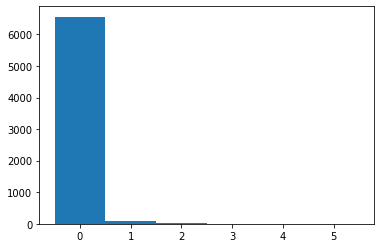

Share of sales that are taken into account in the trainset :  0.8304093567251462


In [6]:
plt.hist(MDP_base_all["y"], bins = np.array(sorted(list(MDP_base_all["y"].unique())+[max(MDP_base_all["y"])+1]))-0.5)
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(MDP_base_all["y"])/np.sum(data["z"]=="sale"))

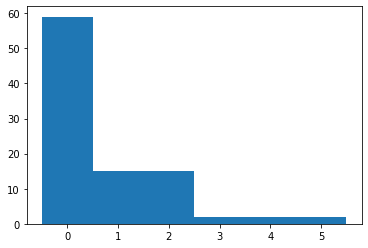

Share of sales that are taken into account in the trainset :  0.18128654970760233


In [7]:
plt.hist(MDP_base["y"], bins = np.array(sorted(list(MDP_base["y"].unique())+[max(MDP_base["y"])+1]))-0.5)
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(MDP_base["y"])/np.sum((data["z"]=="sale")))

 #### V1 : Only attribute reward if the recommended product is sold before the next clicked recommendation

In [8]:
from recogym.agents import FeatureProvider

In [9]:
class ShortTermRewardProvider(FeatureProvider):
    """Reward shaping class"""

    def __init__(self, clicks_only=True):
        self.data_rewards = None
        self.clicks_only = clicks_only
        
    def observe(self, data):
    # List indices that correspond to clicks
        clicked_indices = list(data.loc[data["c"]==1].index)

        # Only keep clicked rows
        if self.clicks_only == True :
            data_clicked = data.loc[data["c"]==1]
        else :
            # Consider unclicked recos as negatives
            data_clicked = data.loc[data["z"]=='bandit']
        data_clicked["y"] = 0

        last_user_clicked = list(data.loc[data["u"]==data.iloc[clicked_indices[len(clicked_indices)-1]].loc["u"]].index)
        last_user_clicked = last_user_clicked[len(last_user_clicked)-1] +1

        # add one value to clicked indices : the last row for the last user who clicked
        clicked_indices += [last_user_clicked]

        for i in range(len(clicked_indices)-1):
            # Only keep the indices before the next time the user clicks
            data_slice = data.iloc[clicked_indices[i]:clicked_indices[i+1]]
            # Only keep the observations for the same user
            data_slice.loc[data_slice["u"]==data_slice["u"].iloc[0]]

            # Count the number of times a sale for the recommended product is observed in the time frame of interest
            data_clicked["y"].iloc[i] = len(data_slice.loc[(data_slice["z"]=="sale") & (data_slice["v"]==data_slice["a"].iloc[0])])
        self.data_rewards = data_clicked

    def features(self):
        return self.data_rewards
    
    def reset(self):
        self.data_rewards = None

In [10]:
st_rewards = ShortTermRewardProvider()
st_rewards_all = ShortTermRewardProvider(clicks_only=False)
st_rewards.observe(data)
data_clicked = st_rewards.features()
data_clicked
# data_clicked.to_csv("data/data_clicked.csv")

,t,u,z,v,a,c,r,ps,ps-a,y
38,38.0,0,bandit,<NA>,0,1.0,1.0,0.1,(),1
65,65.0,0,bandit,<NA>,0,1.0,0.0,0.1,(),0
203,91.0,2,bandit,<NA>,3,1.0,0.0,0.1,(),1
456,181.0,3,bandit,<NA>,5,1.0,0.0,0.1,(),2
760,40.0,8,bandit,<NA>,3,1.0,0.0,0.1,(),0
...,...,...,...,...,...,...,...,...,...,...
8657,95.0,96,bandit,<NA>,5,1.0,1.0,0.1,(),1
8687,125.0,96,bandit,<NA>,2,1.0,1.0,0.1,(),1
8789,55.0,98,bandit,<NA>,0,1.0,0.0,0.1,(),0
8860,38.0,99,bandit,<NA>,5,1.0,1.0,0.1,(),2


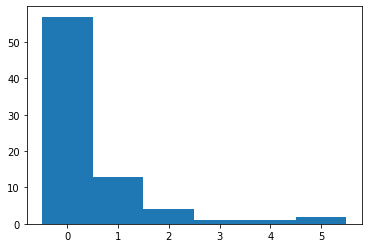

Share of sales that are taken into account in the trainset :  0.2222222222222222


In [11]:
plt.hist(data_clicked["y"], bins = np.array(sorted(list(data_clicked["y"].unique())+[max(data_clicked["y"])+1]))-0.5)
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(data_clicked["y"])/np.sum(data["z"]=="sale"))

#### V2 : Attribute a reward if the product was sold later at one point during the user session

In case of several recommendations for the same product, attribute it to the last time it was recommended.
Thus, for each user : look at every sale, find the last time it was recommended (if any), and give reward

In [12]:
class CumulativeRewardProvider(FeatureProvider):
    """Reward shaping class"""
    
    def __init__(self, clicks_only=True):
        self.data_rewards = None
        self.clicks_only = clicks_only

    def observe(self, data):
        from tqdm import tqdm
        sales_indices = list(data.loc[data["c"]==1].index)
        
        # Only keep clicked rows
        if self.clicks_only == True :
            data_clicked2 = data.loc[data["c"]==1]
        else :
            # Consider unclicked recos as negatives
            data_clicked2 = data.loc[data["z"]=='bandit']
        data_clicked2["y"] = 0

        # Loop over users
        for u in tqdm(data["u"].unique()):
            # Create dataframe with current user
            data_u = data.loc[data["u"]==u]
            # Keep track of indices of sales, and corresponding products
            sales = {"index":data_u.loc[data["z"]=="sale"].index,
                     "product":list(data_u.loc[data["z"]=="sale"]["v"])}
            # Loop over sales
            for i in range(len(sales["index"])):
                # Create dataframe that includes everything up until the sale
                data_slice = data_u.iloc[:sales["index"][i]]
                # Only keep clicked recos that correspond to the sold product
                data_recos = data_slice.loc[(data_slice["c"]==1) & (data_slice["a"]==sales["product"][i])]
                if len(data_recos) > 0 :
                    index = data_recos.index[len(data_recos.index)-1]
                    data_clicked2["y"].loc[data_clicked2.index == index] = data_clicked2["y"].loc[data_clicked2.index == index] + 1
        self.data_rewards = data_clicked2

    def features(self):
        return self.data_rewards
        
    def reset(self):
        self.data_rewards = None

In [13]:
cum_rewards = CumulativeRewardProvider()
cum_rewards_all = CumulativeRewardProvider(clicks_only=False)
cum_rewards.observe(data)
data_clicked2 = cum_rewards.features()
data_clicked2
# data_clicked2.to_csv("data/data_clicked2.csv")

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 76.09it/s]


,t,u,z,v,a,c,r,ps,ps-a,y
38,38.0,0,bandit,<NA>,0,1.0,1.0,0.1,(),1
65,65.0,0,bandit,<NA>,0,1.0,0.0,0.1,(),0
203,91.0,2,bandit,<NA>,3,1.0,0.0,0.1,(),0
456,181.0,3,bandit,<NA>,5,1.0,0.0,0.1,(),1
760,40.0,8,bandit,<NA>,3,1.0,0.0,0.1,(),0
...,...,...,...,...,...,...,...,...,...,...
8657,95.0,96,bandit,<NA>,5,1.0,1.0,0.1,(),1
8687,125.0,96,bandit,<NA>,2,1.0,1.0,0.1,(),1
8789,55.0,98,bandit,<NA>,0,1.0,0.0,0.1,(),0
8860,38.0,99,bandit,<NA>,5,1.0,1.0,0.1,(),0


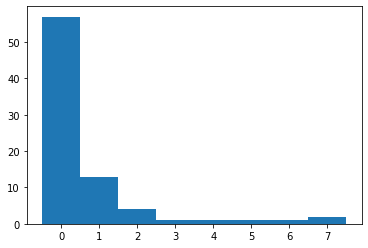

Share of sales that are taken into account in the trainset :  0.25146198830409355


In [14]:
plt.hist(data_clicked2["y"], bins = np.array(sorted(list(data_clicked2["y"].unique())+[max(data_clicked2["y"])+1]))-0.5)
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(data_clicked2["y"])/np.sum(data["z"]=="sale"))

## Build features

In [15]:
from recogym.agents import FeatureProvider

class CountViewsClicksFeatureProvider(FeatureProvider):
    """Feature provider as an abstract class that defines interface of setting/getting features
    The class counts both clicks and views """

    def __init__(self, config):
        super(CountViewsClicksFeatureProvider, self).__init__(config)
        self.num_products = config.num_products
        self.view_feature = np.zeros(self.num_products)
        self.click_feature = np.zeros(self.num_products)
        self.user_features = np.zeros(2*self.num_products)
        
    def observe(self, data):
        if type(data) == pd.core.series.Series:
            row = data
            if row["z"]=='organic':
                self.view_feature[row["v"]] += 1 
            if (row["z"]=='bandit') & (row["c"]==1):
                self.click_feature[row["a"]] += 1 
        else :
            for _, row in data.iterrows():
                if row["z"]=='organic':
                    self.view_feature[int(row["v"])] += 1 
                if (row["z"]=='bandit') & (row["c"]==1):
                    self.click_feature[int(row["a"])] += 1 
                
        self.user_features = np.concatenate([self.view_feature,self.click_feature])
        
    def features(self):
        """Provide feature values adjusted to a particular feature set"""
        return self.user_features

    def reset(self):
        self.view_feature = np.zeros(self.num_products)
        self.click_feature = np.zeros(self.num_products)
        self.user_features = np.zeros(2*self.num_products)

In [16]:
vc_feature = CountViewsClicksFeatureProvider(env.config)

## Build train data based on features and shaped rewards

In [17]:
def build_train_data(logs, feature_provider, reward_provider):
    user_states = []

    # Define clicked logs
    reward_provider.observe(logs)
    clicked_log = reward_provider.features()
    
    # Restrict logs to users that clicked at least once
    logs = logs[logs["u"].isin(list(clicked_log["u"].unique()))]
    
    current_user = None #for checkup
    for index, row in logs.iterrows():
        if current_user != row['u']:
            # User has changed: reset user state.
            current_user = row['u'] #for checkup
            feature_provider.reset()
        
        feature_provider.observe(row)
        
        if index in clicked_log.index :
            user_states.append(feature_provider.features().copy())
            assert clicked_log["u"][index] == current_user

    return (np.array(user_states), 
            np.array(clicked_log["a"]).astype(int), 
            np.array(clicked_log["y"].astype(int)), 
            np.array(clicked_log["ps"]))

In [18]:
# train_st = build_train_data(data, vc_feature, st_rewards)
# train_cum = build_train_data(data, vc_feature, cum_rewards)

In [16]:
# import pickle as pkl
# # Short term
# pkl.dump(train_st,open("data/train_st.pkl","wb"))
# user_states, actions, rewards, proba_actions = pkl.load(open("data/train_st.pkl","rb"))

# # Cumulative
# pkl.dump(train_cum,open("data/train_cum.pkl","wb"))
# user_states, actions, rewards, proba_actions = pkl.load(open("data/train_cum.pkl","rb"))

In [19]:
from recogym.agents import Agent, FeatureProvider
from numpy.random.mtrand import RandomState
from sklearn.linear_model import LogisticRegression
# import pandas as pd
from copy import deepcopy
from scipy.stats.distributions import beta
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from recogym.util import FullBatchLBFGS

In [20]:
class LikelihoodAgent(Agent):
    def __init__(self, feature_provider, reward_provider, epsilon_greedy = False, epsilon = 0.3, seed=43):
        self.feature_provider = feature_provider
        self.reward_provider = reward_provider
        self.random_state = RandomState(seed)
        self.model = None
        self.epsilon_greedy = epsilon_greedy
        self.epsilon = epsilon
        self.ctr = None
        
    @property
    def num_products(self):
        return self.feature_provider.config.num_products
    
    def _create_features(self, user_state, action):
        """Create the features that are used to estimate the expected reward from the user state"""
        features = np.zeros(len(user_state) * self.num_products)
        # perform kronecker product directly on the flattened version of the features matrix
        features[action * len(user_state): (action + 1) * len(user_state)] = user_state
        return features
    
    def train(self, logs):
        user_states, actions, rewards, proba_actions = build_train_data(logs, 
                                                                        self.feature_provider, 
                                                                        self.reward_provider)
        rewards = (rewards > 0)*1
        # Question 1 : estimate sales rate (boolean)
        count_actions = np.unique(actions,return_counts = True)[1]
        assert len(count_actions) == self.num_products
        count_sales_bool = np.array([len(np.where((actions==_) & (rewards>0))[0]) for _ in range(self.num_products)])
        self.salesrate = count_sales_bool / count_actions
#         print("Estimated sales rate : ",self.salesrate)
        
        features = np.vstack([
            self._create_features(user_state, action) 
            for user_state, action in zip(user_states, actions)
        ])
        self.model = LogisticRegression(solver='lbfgs', max_iter=5000)
        self.model.fit(features, rewards)
    
    def _score_products(self, user_state):
        all_action_features = np.array([
            # How do you create the features to feed the logistic model ?
            self._create_features(user_state, action) for action in range(self.num_products)
        ])
        return self.model.predict_proba(all_action_features)[:, 1]
    
    def observation_to_log(self,observation):
        data = {
                    't': [],
                    'u': [],
                    'z': [],
                    'v': [],
                    'a': [],
                    'c': [],
                    'r': [],
                    'ps': [],
                    'ps-a': [],
                }
        def _store_organic(observation):
            assert (observation is not None)
            assert (observation.sessions() is not None)
            for session in observation.sessions():
                data['t'].append(session['t'])
                data['u'].append(session['u'])
                data['z'].append('organic' if session['z']=='pageview' else 'sale') 
                data['v'].append(session['v'])
                data['a'].append(None)
                data['c'].append(None)
                data['r'].append(None) ##H
                data['ps'].append(None)
                data['ps-a'].append(None)

        def _store_clicks(observation):
            assert (observation is not None)
            assert (observation.click is not None)
            for session in observation.click:
                data['t'].append(session['t'])
                data['u'].append(session['u'])
                data['z'].append('bandit') 
                data['v'].append(None)
                data['a'].append(session['a'])
                data['c'].append(session['c'])
                data['r'].append(None) 
                data['ps'].append(None)
                data['ps-a'].append(None)

        _store_organic(observation)
        _store_clicks(observation)
        df = pd.DataFrame(data)
        df.sort_values('t')
        return df
        
    
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past history"""
        logged_observation = self.observation_to_log(observation)
        self.feature_provider.observe(logged_observation)      
        user_state = self.feature_provider.features()
        if (self.epsilon_greedy == True) & (np.random.rand() < self.epsilon) : 
            print("Explore")
            action = np.random.randint(self.num_products())
        else :
            action = np.argmax(self._score_products(user_state))
        
        ps = 1.0
        all_ps = np.zeros(self.num_products)
        all_ps[action] = 1.0        
        
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': ps,
                'ps-a': all_ps,
            }
        }

    def reset(self):
        self.feature_provider.reset()  

In [21]:
from recogym.agents import RandomAgent, random_args
random_agent = RandomAgent(Configuration(random_args))

from recogym.agents.sale_oracle import ClickViewSaleOracleAgent
env.reset()
cvs_oracle = ClickViewSaleOracleAgent(env=env)
cvs_oracle.reset()

from recogym.agents.sale_oracle import ClickSaleOracleAgent
env.reset()
cs_oracle = ClickSaleOracleAgent(env=env)
cs_oracle.reset()

from recogym.agents.sale_count_oracle import ClickViewSaleCountOracleAgent
env.reset()
cvs_count_oracle = ClickViewSaleCountOracleAgent(env=env)
cvs_count_oracle.reset()

from recogym.agents.sale_count_oracle import ClickSaleCountOracleAgent
env.reset()
cs_count_oracle = ClickSaleCountOracleAgent(env=env)
cs_count_oracle.reset()

from recogym.agents.sale_oracle import ClickViewExpectSalesOracleAgent
env.reset()
cves_oracle = ClickViewExpectSalesOracleAgent(env = env)
cves_oracle.reset()

from recogym.agents.sale_oracle import ClickViewExpectGhostSalesOracleAgent
env.reset()
cvegs_oracle = ClickViewExpectGhostSalesOracleAgent(env = env)
cvegs_oracle.reset()

from recogym.agents.sale_count_oracle import ClickViewExpectSalesCountOracleAgent
env.reset()
cvesc_oracle = ClickViewExpectSalesCountOracleAgent(env = env)
cvesc_oracle.reset()

# likelihood_logreg_cum = LikelihoodAgent(vc_feature, cum_rewards)
# likelihood_logreg_cum.train(data)

# likelihood_logreg_st = LikelihoodAgent(vc_feature, st_rewards)
# likelihood_logreg_st.train(data)

In [101]:
test=verify_agents_sale(
    env,
    number_of_users=10,
    agents={
        'random agent' : random_agent,
#         'likelihood st': likelihood_logreg_st
        'likelihood cum': likelihood_logreg_cum,
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.92it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]


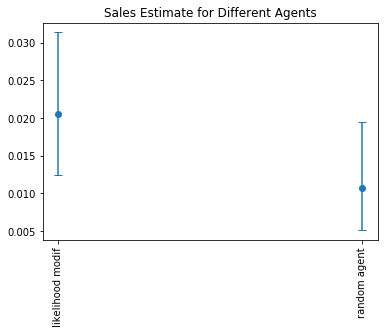

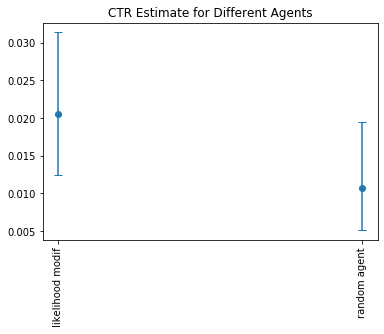

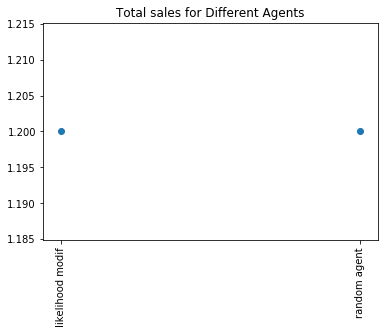

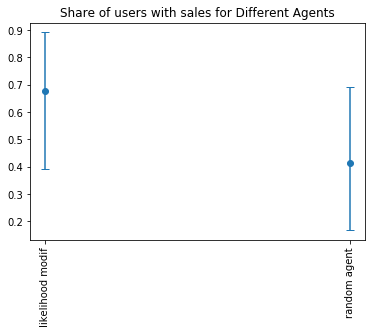

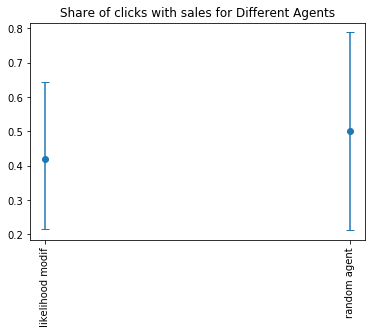

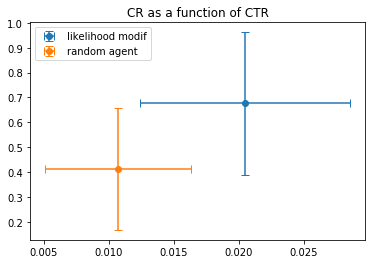

In [103]:
plot_verify_agents_sale(test["sale rate"], test["CTR"], test["Tot sales"], 
                        test['Share user with sale'], test['Share sale after click'],
                       test["User embeddings"])
None

In [107]:
res_likelihood=verify_agents_sale(
    env,
    number_of_users=1000,
    agents={
        'random agent' : random_agent,
        'likelihood st': likelihood_logreg_st,
        'likelihood cum': likelihood_logreg_cum
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.64it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [24:44<00:00,  1.48s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [26:10<00:00,  1.57s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to mat

In [109]:
import pickle as pkl
pkl.dump(res_likelihood,open("data/res_likelihood.pkl","wb"))
pkl.dump(test,open("data/res_likelihood_initial_test.pkl","wb"))

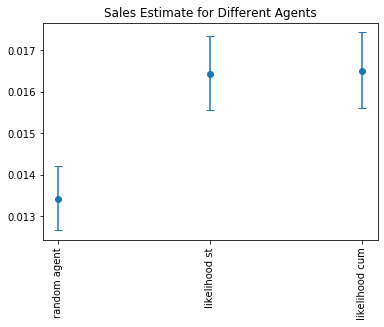

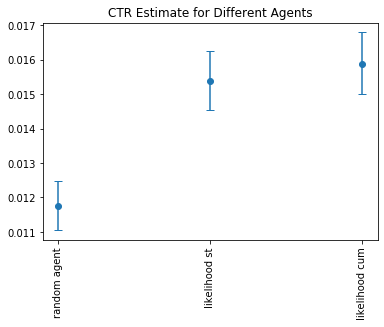

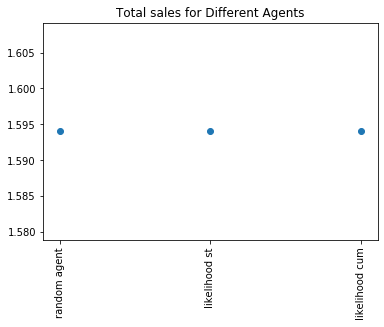

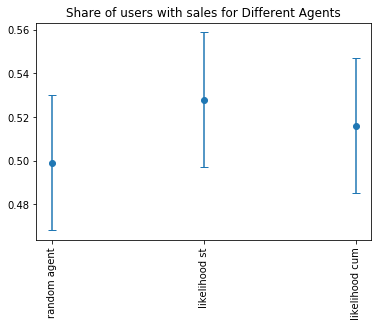

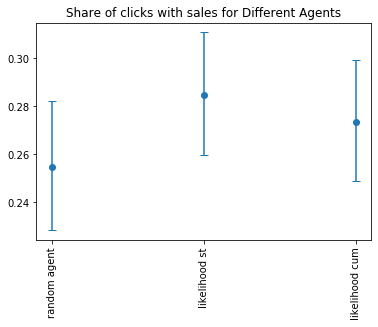

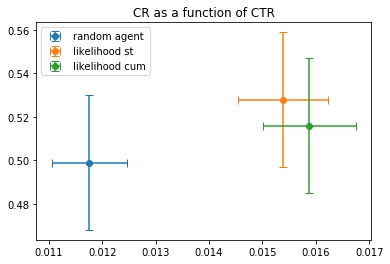

In [110]:
res = res_likelihood
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [129]:
likelihood_logreg_cum_all = LikelihoodAgent(vc_feature, cum_rewards_all)
likelihood_logreg_cum_all.train(data)

likelihood_logreg_st_all = LikelihoodAgent(vc_feature, st_rewards_all)
likelihood_logreg_st_all.train(data)


likelihood_logreg_cum = LikelihoodAgent(vc_feature, cum_rewards)
likelihood_logreg_cum.train(data)

likelihood_logreg_st = LikelihoodAgent(vc_feature, st_rewards)
likelihood_logreg_st.train(data)

res_likelihood=verify_agents_sale(
    env,
    number_of_users=1000,
    agents={
        'random agent' : random_agent,
        'likelihood st all': likelihood_logreg_st_all,
        'likelihood cum all': likelihood_logreg_cum_all,
        'likelihood st': likelihood_logreg_st,
        'likelihood cum': likelihood_logreg_cum
    }
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.50it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.03it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [26:18<00:00,  1.58s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [29:56<00:00,  1.80s/it]
C:\Use

In [130]:
pkl.dump(res_likelihood,open("data/res_likelihood_all.pkl","wb"))

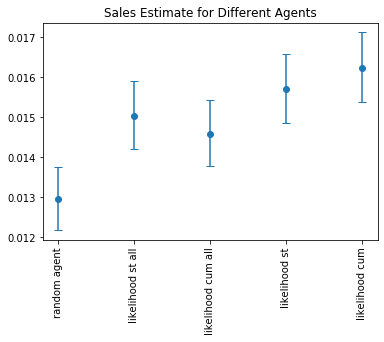

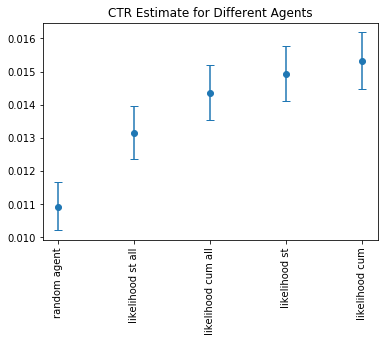

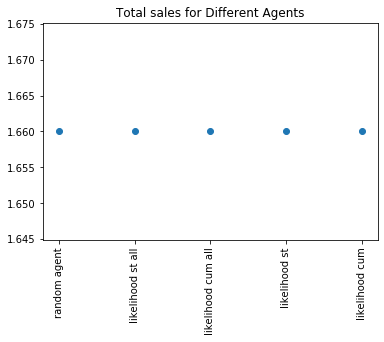

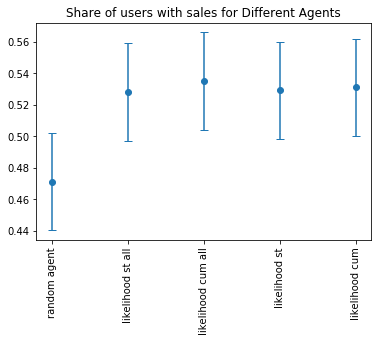

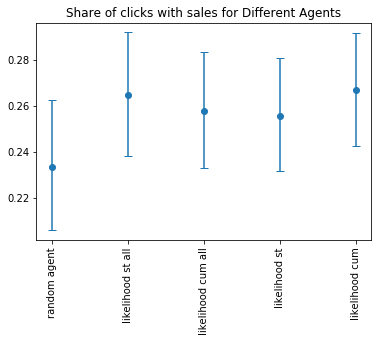

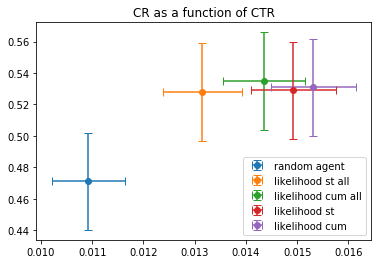

In [131]:
res = res_likelihood
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [34]:
likelihood_logreg_mdp_all = LikelihoodAgent(vc_feature, MDP_rewards_all)
likelihood_logreg_mdp_all.train(data)

likelihood_logreg_cum_all = LikelihoodAgent(vc_feature, cum_rewards_all)
likelihood_logreg_cum_all.train(data)

likelihood_logreg_st_all = LikelihoodAgent(vc_feature, st_rewards_all)
likelihood_logreg_st_all.train(data)


likelihood_logreg_mdp = LikelihoodAgent(vc_feature, MDP_rewards)
likelihood_logreg_mdp.train(data)

likelihood_logreg_cum = LikelihoodAgent(vc_feature, cum_rewards)
likelihood_logreg_cum.train(data)

likelihood_logreg_st = LikelihoodAgent(vc_feature, st_rewards)
likelihood_logreg_st.train(data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 37.02it/s]


In [141]:
res_all_test=verify_agents_sale(
    env,
    number_of_users=100,
    agents={
        'random agent' : random_agent,
        'likelihood ST all': likelihood_logreg_st_all,
        'likelihood cum all': likelihood_logreg_cum_all,
        'likelihood ST': likelihood_logreg_st,
        'likelihood cum': likelihood_logreg_cum,
        'cvs_oracle':cvs_oracle,
        'cs_oracle':cs_oracle,
        'cvs_count_oracle':cvs_count_oracle,
        'cs_count_oracle':cs_count_oracle,
        'cves_oracle':cves_oracle,
        'cvegs_oracle':cvegs_oracle,
        'cvesc_oracle':cvesc_oracle
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.60it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.30s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [04:52<00:00,  2.92s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to mat

In [142]:
pkl.dump(res_all_test,open("data/res_all_test.pkl","wb"))

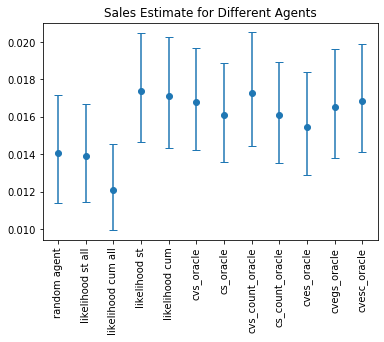

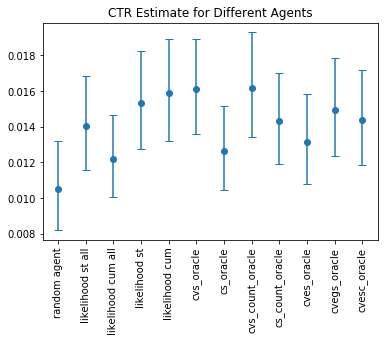

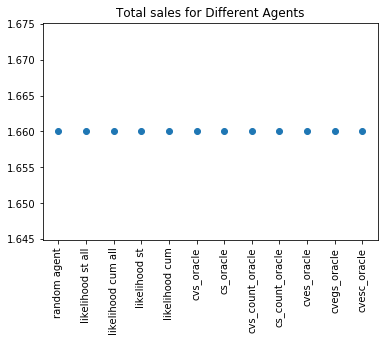

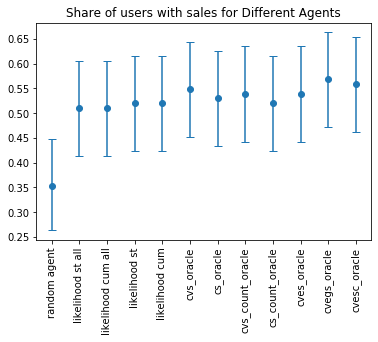

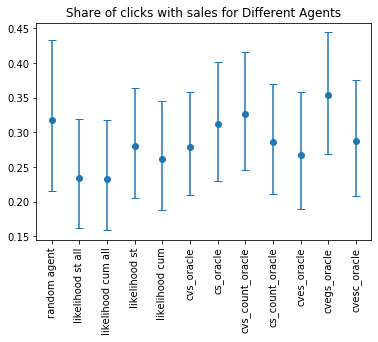

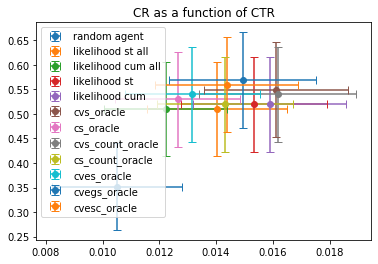

In [147]:
res = res_all_test
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [149]:
res_all_test2=verify_agents_sale(
    env,
    number_of_users=100,
    agents={
        'random agent' : random_agent,
        'likelihood MDP all': likelihood_logreg_mdp_all,
        'likelihood ST all': likelihood_logreg_st_all,
        'likelihood cum all': likelihood_logreg_cum_all,
        'likelihood MDP': likelihood_logreg_mdp,
        'likelihood ST': likelihood_logreg_st,
        'likelihood cum': likelihood_logreg_cum,
        'cvs_oracle':cvs_oracle,
        'cs_oracle':cs_oracle,
        'cvs_count_oracle':cvs_count_oracle,
        'cs_count_oracle':cs_count_oracle,
        'cves_oracle':cves_oracle,
        'cvegs_oracle':cvegs_oracle,
        'cvesc_oracle':cvesc_oracle
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.09it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.83s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [04:32<00:00,  2.73s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to mat

In [150]:
pkl.dump(res_all_test2,open("data/res_all_test2.pkl","wb"))

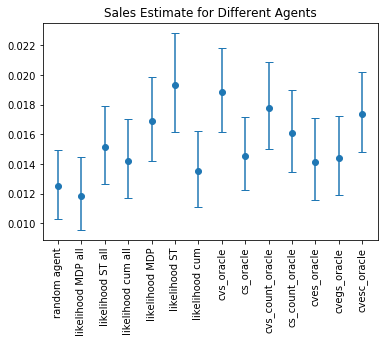

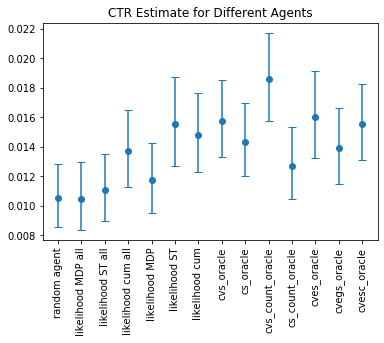

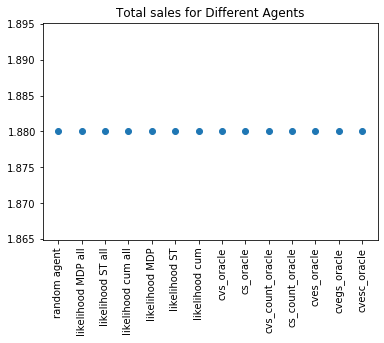

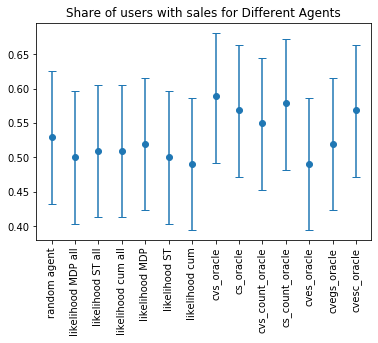

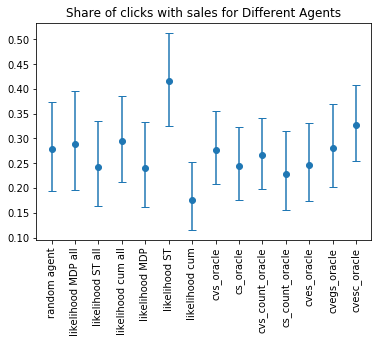

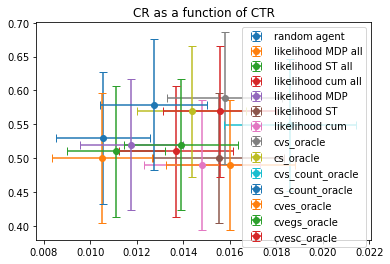

In [151]:
res = res_all_test2
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

In [ ]:
res_all_test3=verify_agents_sale(
    env,
    number_of_users=1000,
    agents={
        'random agent' : random_agent,
        'likelihood MDP all': likelihood_logreg_mdp_all,
        'likelihood ST all': likelihood_logreg_st_all,
        'likelihood cum all': likelihood_logreg_cum_all,
        'likelihood MDP': likelihood_logreg_mdp,
        'likelihood ST': likelihood_logreg_st,
        'likelihood cum': likelihood_logreg_cum,
        'cvs_oracle':cvs_oracle,
        'cs_oracle':cs_oracle,
        'cvs_count_oracle':cvs_count_oracle,
        'cs_count_oracle':cs_count_oracle,
        'cves_oracle':cves_oracle,
        'cvegs_oracle':cvegs_oracle,
        'cvesc_oracle':cvesc_oracle
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.41it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [23:15<00:00,  1.40s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users:  64%|██████████████████████████████████████████████▏                         | 641/1000 [14:07<04:37,  1.29it/s]

In [ ]:
pkl.dump(res_all_test3,open("data/res_all_test3.pkl","wb"))

In [ ]:
res = res_all_test3
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None

### Organic user counter as logging policy

In [22]:
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args

organic_counter_agent = OrganicUserEventCounterAgent(
    Configuration({
        **organic_user_count_args,
        **env_1_sale_args,
        'select_randomly': True,
    })
)
result = verify_agents_sale(
    env,
    number_of_users=2000,
    agents={
        'Organic Count': organic_counter_agent
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:28<00:00, 22.52it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]


In [23]:
# from recogym.envs.utils_sale import PopularityAgent
# popagent=PopularityAgent(Configuration({**env_1_sale_args,'num_products': num_products}))
# pop_result = verify_agents_sale(
#     env,
#     number_of_users=1000,
#     agents={
#         'pop agent': organic_counter_agent
#     }
# )

In [24]:
num_users = 1000
data_sm = deepcopy(env).generate_logs(num_users, agent=organic_counter_agent)
# data_sm = deepcopy(env).generate_logs(num_users, agent=popagent)
display(data_sm)
data = data_sm

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.16it/s]


,t,u,z,v,a,c,r,ps,ps-a
0,0.0,0,organic,3,<NA>,NaN,NaN,NaN,None
1,1.0,0,bandit,<NA>,3,0.0,0.0,1.000000,()
2,2.0,0,bandit,<NA>,3,0.0,0.0,1.000000,()
3,3.0,0,bandit,<NA>,3,0.0,0.0,1.000000,()
4,4.0,0,bandit,<NA>,3,0.0,0.0,1.000000,()
...,...,...,...,...,...,...,...,...,...
101235,53.0,999,bandit,<NA>,0,0.0,0.0,0.727273,()
101236,54.0,999,bandit,<NA>,0,0.0,0.0,0.727273,()
101237,55.0,999,bandit,<NA>,0,0.0,0.0,0.727273,()
101238,56.0,999,bandit,<NA>,0,0.0,0.0,0.727273,()


In [25]:
likelihood_logreg_mdp_all = LikelihoodAgent(vc_feature, MDP_rewards_all)
likelihood_logreg_mdp_all.train(data)

likelihood_logreg_cum_all = LikelihoodAgent(vc_feature, cum_rewards_all)
likelihood_logreg_cum_all.train(data)

likelihood_logreg_st_all = LikelihoodAgent(vc_feature, st_rewards_all)
likelihood_logreg_st_all.train(data)


likelihood_logreg_mdp = LikelihoodAgent(vc_feature, MDP_rewards)
likelihood_logreg_mdp.train(data)

likelihood_logreg_cum = LikelihoodAgent(vc_feature, cum_rewards)
likelihood_logreg_cum.train(data)

likelihood_logreg_st = LikelihoodAgent(vc_feature, st_rewards)
likelihood_logreg_st.train(data)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.54it/s]


In [29]:
res_all_test_organic=verify_agents_sale(
    env,
    number_of_users=100,
    agents={
        'random agent' : random_agent,
        'organic user' : organic_counter_agent,
        'likelihood MDP all': likelihood_logreg_mdp_all,
        'likelihood ST all': likelihood_logreg_st_all,
        'likelihood cum all': likelihood_logreg_cum_all,
        'likelihood MDP': likelihood_logreg_mdp,
        'likelihood ST': likelihood_logreg_st,
        'likelihood cum': likelihood_logreg_cum,
        'cvs_oracle':cvs_oracle,
        'cs_oracle':cs_oracle,
        'cvs_count_oracle':cvs_count_oracle,
        'cs_count_oracle':cs_count_oracle,
        'cves_oracle':cves_oracle,
        'cvegs_oracle':cvegs_oracle,
        'cvesc_oracle':cvesc_oracle
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.07it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.08it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:703: UserWarning: Boolean Series key will be reindexed to mat

In [31]:
import pickle as pkl
pkl.dump(res_all_test_organic,open("data/res_all_test_organic.pkl","wb"))

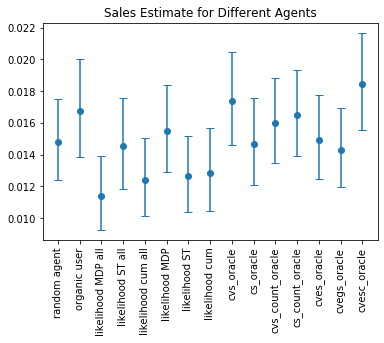

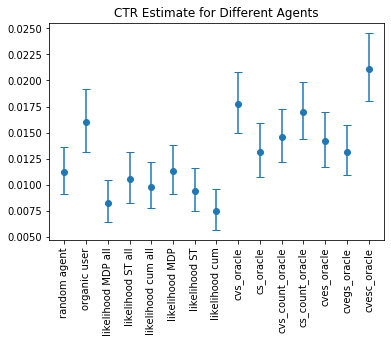

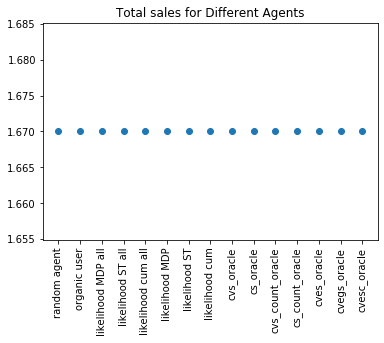

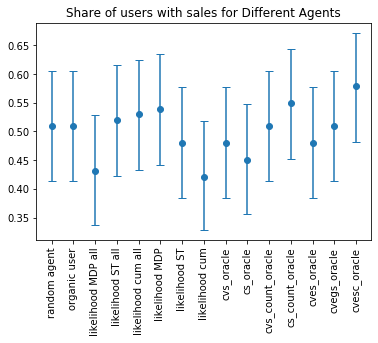

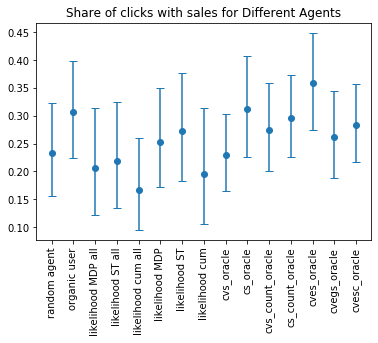

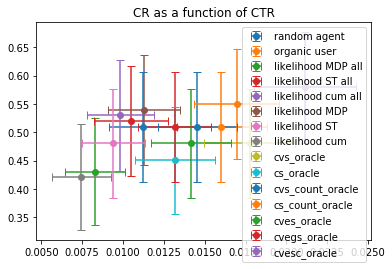

In [32]:
res = res_all_test_organic
plot_verify_agents_sale(res["sale rate"], res["CTR"], res["Tot sales"], 
                        res['Share user with sale'], res['Share sale after click'],
                       res["User embeddings"])
None